In [1]:
pip install PyPortfolioOpt

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.3.0/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yfinance

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.3.0/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pulp

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.3.0/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install quandl

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.3.0/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [21]:
#Hierarchical Risk Parity (Lopez de Prado 2016)

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import matplotlib

In [22]:
df= pd.read_csv("input_data.csv")
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index("Date", inplace = True)
returns=df.pct_change()
returns.head()

,DAI-USD,BUSD-USD,TUSD-USD,USDC-USD,USDT-USD
Date,,,,,
2019-11-22,NaN,NaN,NaN,NaN,NaN
2019-11-23,0.023861,0.009837,0.009095,0.010484,0.010054
2019-11-24,-0.013788,0.007578,0.006457,-0.002832,0.004332
2019-11-25,0.004740,-0.016237,-0.013968,-0.008411,-0.014157
2019-11-26,-0.000919,0.006695,0.005833,0.007539,0.006638


In [23]:
returns.columns

Index(['DAI-USD', 'BUSD-USD', 'TUSD-USD', 'USDC-USD', 'USDT-USD'], dtype='object')

In [24]:
# correlation matrix
corr_matrix = returns.corr()
# distance matrix
dist_corr = np.sqrt(0.5*(1-corr_matrix))

In [25]:
# correlation matrix
# corr replaced by corr_matrix = returns.corr() 
# distance matrix
# d_corr replaced by dist_corr = np.sqrt(0.5*(1-corr))

/var/folders/dh/cjyd2n_s6jv3g6srpjrvn0hw0000gn/T/ipykernel_19051/1266265395.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = linkage(dist_corr, 'single')


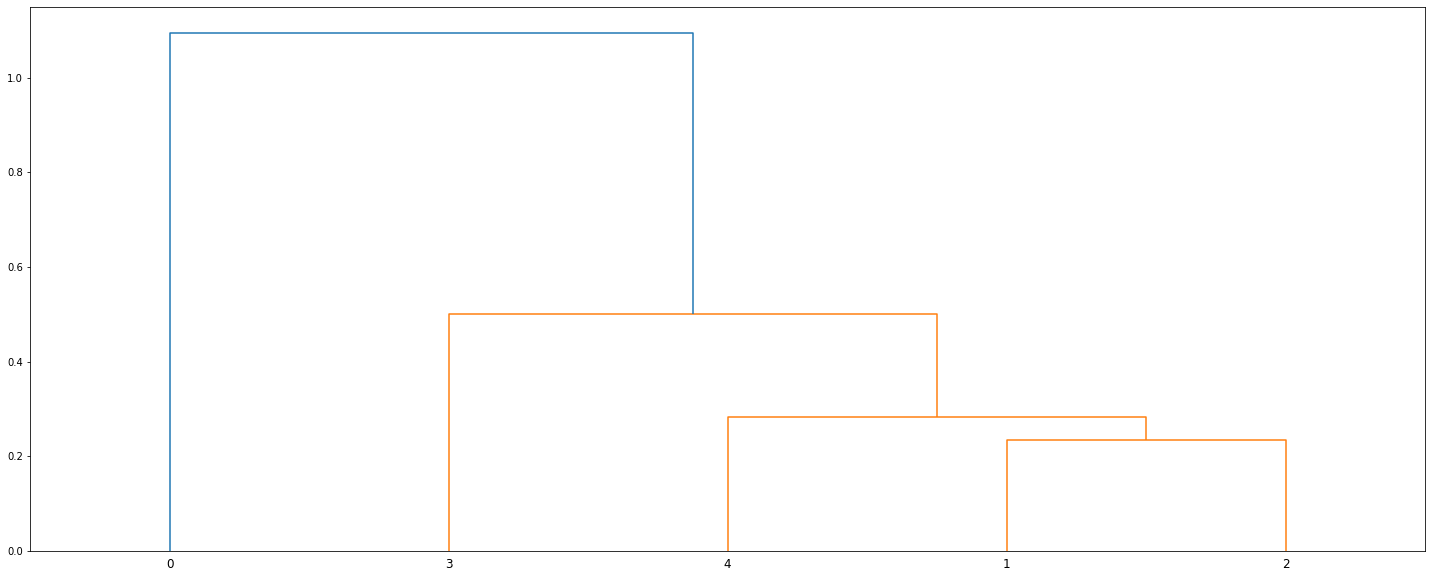

In [26]:
# Performing hierarchical/agglomerative clustering.
linkage = linkage(dist_corr, 'single')
Ze = pd.DataFrame(linkage)

fig = plt.figure(figsize=(25, 10))
dendogram = dendrogram(Ze)
# plt.show()

In [27]:
Ze

,0,1,2,3
0,1.0,2.0,0.235143,2.0
1,4.0,5.0,0.282363,3.0
2,3.0,6.0,0.500435,4.0
3,0.0,7.0,1.094215,5.0


In [28]:
def quasi_diagonalization(linkage):
    
    # The clustered items are sorted based on their distance
    
    linkage = linkage.astype(int)
    
    # The last quadriplets first and second consituent items are taken
    sort_last = pd.Series([linkage[-1,0], linkage[-1,1]]) 
    
    # The third element of the constituent set represents the total items
    num_items = linkage[-1, 3]
    
  
    # if the max_times is less than or equal to the maximum of sort_last
    while sort_last.max() >= num_items:
        # we assign a 24 by 24 sort_last index 
        sort_last.index = range(0, sort_last.shape[0]*2, 2) 
        # the odd numbers are indexed
        
        df0 = sort_last[sort_last >= num_items] # finding clusters
        
      
        # the cluster and even index are contained in df0
        i = df0.index
        j = df0.values - num_items  
        
        sort_last[i] = linkage[j,0] # item#1
        
        df0  = pd.Series(linkage[j, 1], index=i+1)
        
        sort_last = sort_last.append(df0)
        sort_last = sort_last.sort_index()
        
        sort_last.index = range(sort_last.shape[0])
        
    
    return sort_last.tolist()

In [29]:
sort_last = quasi_diagonalization(linkage)
sort_last

/var/folders/dh/cjyd2n_s6jv3g6srpjrvn0hw0000gn/T/ipykernel_19051/997907776.py:31: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sort_last = sort_last.append(df0)
/var/folders/dh/cjyd2n_s6jv3g6srpjrvn0hw0000gn/T/ipykernel_19051/997907776.py:31: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sort_last = sort_last.append(df0)
/var/folders/dh/cjyd2n_s6jv3g6srpjrvn0hw0000gn/T/ipykernel_19051/997907776.py:31: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sort_last = sort_last.append(df0)


[0, 3, 4, 1, 2]

In [30]:
def cluster_variable(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # slice of matrix
    # now we calculate the inverse variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var

def recursive_bisection(cov, sort_last):
    # computing Hierarchical Risk Parity allocation
    # intializing weights of one
    w = pd.Series(1, index=sort_last)
    
    # intializing all items in a single cluster
    c_items = [sort_last]
    while len(c_items) > 0:
        # recursive bisection
        """
        [[3, 6, 0, 9, 2, 4, 13], [5, 12, 8, 10, 7, 1, 11]]
        [[3, 6, 0], [9, 2, 4, 13], [5, 12, 8], [10, 7, 1, 11]]
        [[3], [6, 0], [9, 2], [4, 13], [5], [12, 8], [10, 7], [1, 11]]
        [[6], [0], [9], [2], [4], [13], [12], [8], [10], [7], [1], [11]]
        """
        c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        
        # now it has 2
        for i in range(0, len(c_items), 2):
            
            c_items0 = c_items[i] # first cluster
            c_items1 = c_items[i+1] # second cluster
            
            c_var0 = cluster_variable(cov, c_items0)
            c_var1 = cluster_variable(cov, c_items1)
            
            alpha = 1 - c_var0/(c_var0+c_var1)
            
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha
    return w

In [31]:
covariance = returns.cov()
weights = recursive_bisection(covariance, sort_last)

In [32]:
new_index = [returns.columns[i] for i in weights.index]
weights.index = new_index

In [33]:
weights

DAI-USD     0.086206
USDC-USD    0.403979
USDT-USD    0.247499
BUSD-USD    0.119251
TUSD-USD    0.143065
dtype: float64